In [1]:
%load_ext cython
%load_ext autoreload
%autoreload 2

import numpy as np
from test_model import make_sin_data, LnLikelihood, LnPrior
from impulse.base import PTTestSampler

import matplotlib.pyplot as plt

import corner

from impulse.ptsampler import PTState

In [5]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

In [6]:
lnlike = LnLikelihood(x, data)
lnprior = LnPrior([0, 0, 0], [3, 5, np.pi])

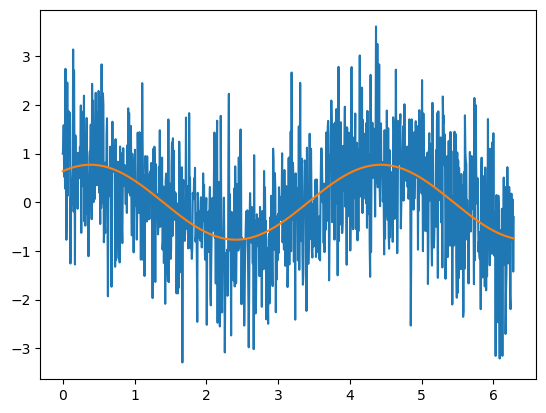

In [7]:
plt.plot(x, data)
plt.plot(x, a_real * np.sin(omega_real*x + phi_real))

In [11]:
# grid approximate the posterior:
omega = np.linspace(0, 3, 1000)
a = np.linspace(0, 5, 1000)
phi = np.linspace(0, np.pi, 1000)
lnpost = np.zeros((1000, 1000, 1000))


In [10]:
%%cython

cpdef double lnlike_cython(double omega, double a, double phi,
                           double[:] x, double[:] data, double[:] lnpost):
    cdef int i, j, k
    for i in range(1000):
        for j in range(1000):
            for k in range(1000):
                for m in range(1000):
                    func = a[i] * np.sin(omega[j]*x[m] + phi[k])
                    lnpost[i, j, k] += -0.5 * (data[m] - func)**2



Error compiling Cython file:
------------------------------------------------------------
...
    cdef int i, j, k
    for i in range(1000):
        for j in range(1000):
            for k in range(1000):
                for m in range(1000):
                    func = a[i] * np.sin(omega[j]*x[m] + phi[k])
                            ^
------------------------------------------------------------

/Users/aaron/.ipython/cython/_cython_magic_d10dc0c49c5489394000cd5e84316863883f29ae.pyx:9:28: Attempting to index non-array type 'double'

Error compiling Cython file:
------------------------------------------------------------
...
    cdef int i, j, k
    for i in range(1000):
        for j in range(1000):
            for k in range(1000):
                for m in range(1000):
                    func = a[i] * np.sin(omega[j]*x[m] + phi[k])
                                  ^
------------------------------------------------------------

/Users/aaron/.ipython/cython/_cython_magic_d10dc0c49c5

In [166]:
total = np.zeros((1000, 1000, 1000))
for ii in range(len(x)):
    total += -0.5 * (np.multiply.outer(a, np.sin(np.add.outer(np.multiply(omega, x[ii]), phi))) - data[ii])**2

KeyboardInterrupt: 

In [128]:
for ii in range(5):
    print(np.multiply.outer(a, np.sin(np.add.outer(omega * x[ii], phi))).shape)

(100, 100, 100)
(100, 100, 100)
(100, 100, 100)
(100, 100, 100)
(100, 100, 100)


In [152]:
phi_real

1.8765815378527688

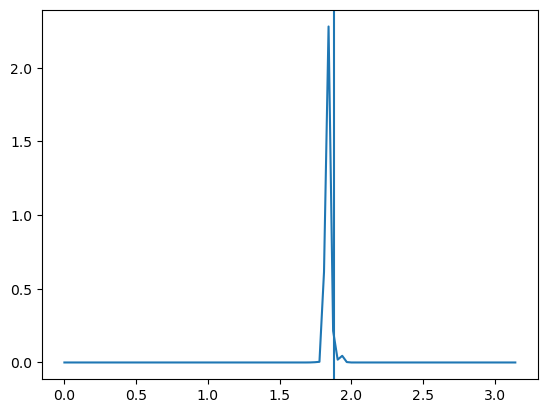

In [163]:
plt.plot(phi, np.sum(np.exp(total - np.max(total)), axis=(0, 1)))
plt.axvline(phi_real)

In [ ]:
class LnLikelihood():
    def __init__(self, x, data, sigma=1):
        self.x = x
        self.sigma = sigma
        self.data = data

    def __call__(self, params):
        omega = params[0]
        a = params[1]
        phi = params[2]
        func = a * np.sin(omega * self.x + phi)
        result = np.sum(-0.5 * (func - self.data)**2)
        if np.isfinite(result):
            return result
        else:
            return -np.inf

In [108]:
omega_real

2.6273187015923556

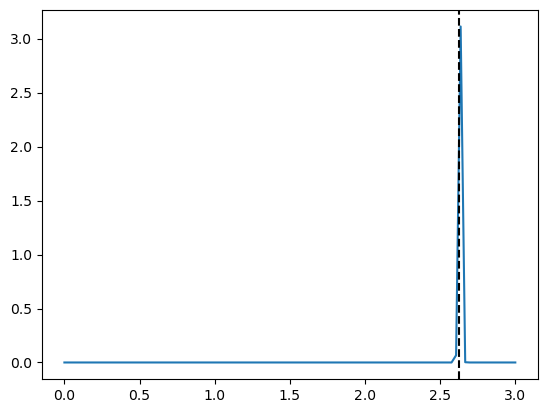

In [109]:
plt.plot(phi, np.sum(np.sum(np.exp(lnpost), axis=1), axis=1))
plt.axvline(omega_real, color='k', linestyle='--')

In [85]:
sampler = PTTestSampler(3, lnlike, lnprior, cov_update=100, ntemps=4, swap_steps=10, max_temp=2.0)

In [86]:
sampler.sample(np.array([2, 3, 1]), 100_000, thin=1)

 21%|██        | 20601/100000 [00:08<00:32, 2452.17it/s]/Users/aaron/Documents/GitHub/impulse_mcmc/impulse/ptsampler.py:92: RuntimeWarning: overflow encountered in exp
  acc_ratio = np.exp(log_acc_ratio)
100%|██████████| 100000/100000 [00:39<00:00, 2513.32it/s]


In [87]:
from emcee.autocorr import integrated_time

In [88]:
chains = []
for ii in range(4):
    with open(f'/Users/aaron/Documents/GitHub/impulse_mcmc/examples/chains/chain_{ii}.txt') as fp:
        chains.append(np.loadtxt(fp))

In [89]:
integrated_time(chain[20_000::1, 2])

array([17.27317743])

In [90]:
print(omega_real, a_real, phi_real)

2.6273187015923556 2.7268532639648075 1.8765815378527688


(-1.0, 1.0)

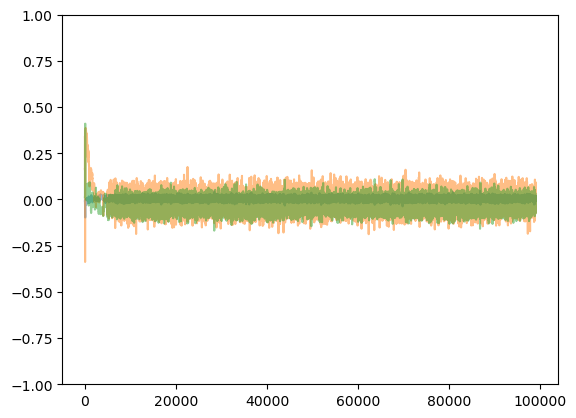

In [91]:
plt.plot(chain[:, 0] - omega_real, alpha = 0.5)
plt.plot(chain[:, 1] - a_real, alpha = 0.5)
plt.plot(chain[:, 2] - phi_real, alpha = 0.5)
plt.ylim([-1, 1])

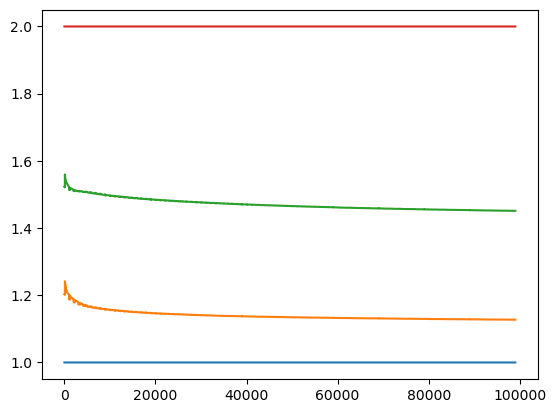

In [92]:
plt.plot(chains[0][:, -1])
plt.plot(chains[1][:, -1])
plt.plot(chains[2][:, -1])
plt.plot(chains[3][:, -1])

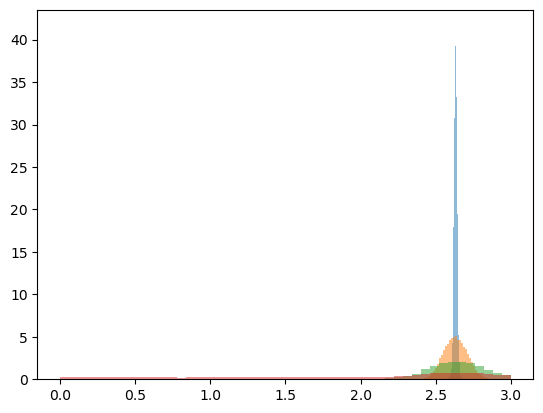

In [93]:
plt.hist(chains[0][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[1][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[2][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[3][:, 0], alpha=0.5, bins=50, density=True);


In [98]:
integrated_time(chains[0][20_000::1, 2])

array([16.36799042])

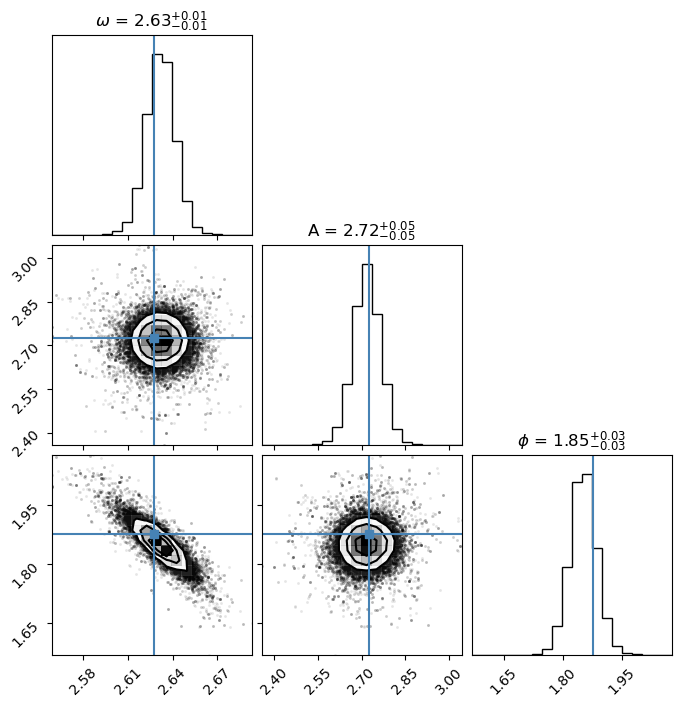

In [102]:
burn = 20_000

corner.corner(chains[0][burn::1, :3], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()

In [14]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [15]:
sampler = ptmcmc(3, lnlike, lnprior, cov=np.eye(3), outDir='./sine_chains')

In [42]:
sampler.sample(np.array([2., 3., 1.]), Niter=100_000, thin=1, SCAMweight=30, AMweight=15, DEweight=50)

Finished 10.00 percent in 0.799068 s Acceptance rate = 0.34677Adding DE jump with weight 50
Finished 99.00 percent in 7.817213 s Acceptance rate = 0.205192
Run Complete


In [43]:
with open('./sine_chains/chain_1.txt', 'r') as fp:
    chain = np.loadtxt(fp)

In [44]:
chain.shape

(99000, 7)

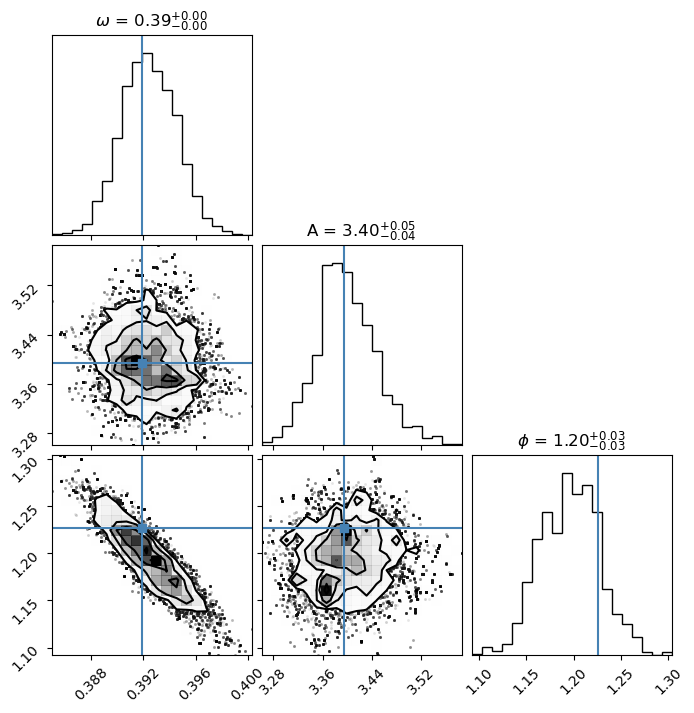

In [45]:
corner.corner(chain[20_000:, :-4],truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True);

(-1.0, 1.0)

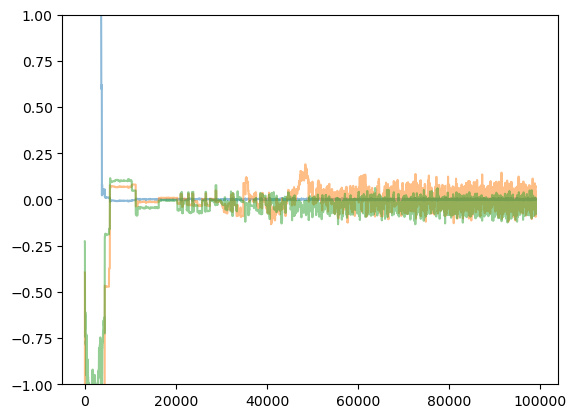

In [46]:
plt.plot(chain[:, 0] - omega_real, alpha = 0.5)
plt.plot(chain[:, 1] - a_real, alpha = 0.5)
plt.plot(chain[:, 2] - phi_real, alpha = 0.5)
plt.ylim([-1, 1])

In [47]:
integrated_time(chain[20_000:, 1])

array([1186.18110085])